# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


keras = tf.keras

In [2]:
# Set default figsize to 10 inches by 6 inches
plt.rcParams["figure.figsize"] = (10,6)

# Functions

In [3]:
def plot_series(time,series,format='-',start=0,end=None,label=None):
      """
      Plots a time series
      If the label != None, Sets a legend 
      """
      plt.plot(time[start:end], series[start:end], format, label=label)
      plt.xlabel("Time")
      plt.ylabel("Value")
      if label:
          plt.legend(fontsize=14)
      plt.grid(True)

In [4]:
def trend(time, slope=0):
  return slope * time

In [5]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [6]:
def seasonality(time,period,amplitude=1,phase=0):
  """
  Repeats the same patterns at each period
  """
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [7]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Setting up the data

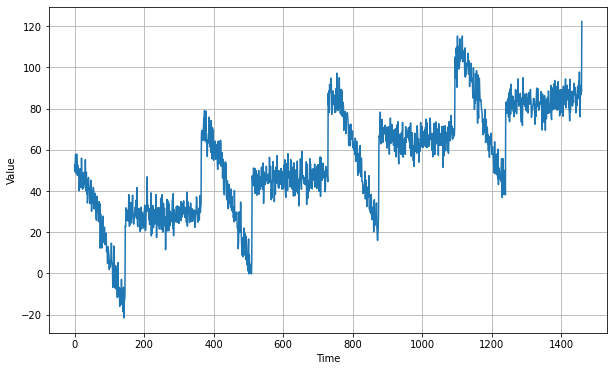

In [8]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plot_series(time, series)
plt.show()

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Stateful RNN forecasting

In [10]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [12]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [13]:
%%time

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 5s 26ms/step - loss: 119.4312 - mae: 119.9312
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 90.0518 - mae: 90.5518
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 56.3639 - mae: 56.8630
Epoch 4/100
33/33 [==============================] - 1s 24ms/step - loss: 35.0964 - mae: 35.5923
Epoch 5/100
33/33 [==============================] - 1s 24ms/step - loss: 30.4513 - mae: 30.9471
Epoch 6/100
33/33 [==============================] - 1s 24ms/step - loss: 29.5937 - mae: 30.0834
Epoch 7/100
33/33 [==============================] - 1s 24ms/step - loss: 28.6775 - mae: 29.1709
Epoch 8/100
33/33 [==============================] - 1s 24ms/step - loss: 27.6872 - mae: 28.1803
Epoch 9/100
33/33 [==============================] - 1s 24ms/step - loss: 26.8164 - mae: 27.3123
Epoch 10/100
33/33 [==============================] - 1s 24ms/step - loss: 25.9618 - mae: 26.4572
Epoch 11/100
33/33 [=======

(1e-08, 0.0001, 0.0, 30.0)

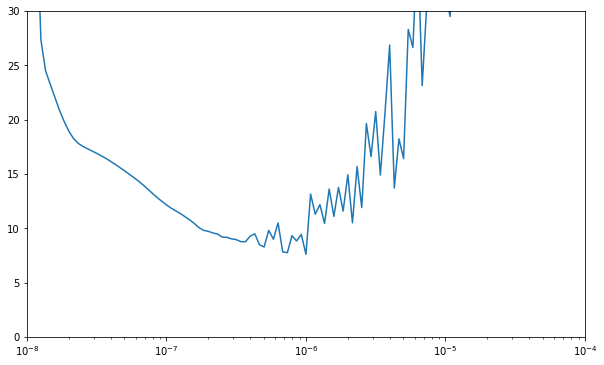

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Time for the real model

In [15]:
%%time 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 43ms/step - loss: 92.9155 - mae: 93.4144 - val_loss: 25.0214 - val_mae: 25.5175
Epoch 2/500
33/33 [==============================] - 1s 29ms/step - loss: 29.4369 - mae: 29.9290 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 29ms/step - loss: 25.5872 - mae: 26.0791 - val_loss: 12.0569 - val_mae: 12.5480
Epoch 4/500
33/33 [==============================] - 1s 30ms/step - loss: 23.9572 - mae: 24.4492 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 29ms/step - loss: 23.0645 - mae: 23.5578 - val_loss: 9.9581 - val_mae: 10.4500
Epoch 6/500
33/33 [==============================] - 1s 31ms/step - loss: 22.0755 - mae: 22.5678 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 29ms/step - loss: 21.2401 - mae: 21.7314 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [16]:
model = keras.models.load_model('my_checkpoint.h5')

In [17]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [18]:
rnn_forecast.shape

(461,)

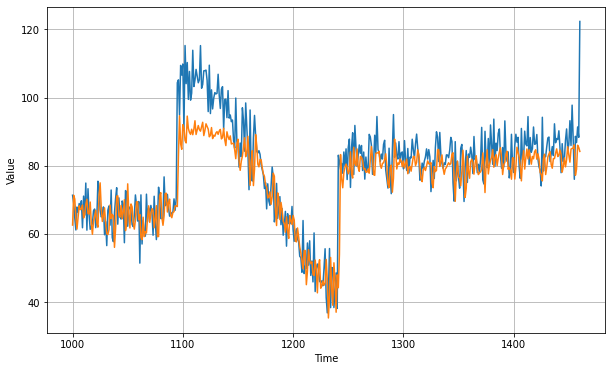

In [19]:
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778473